# Qcodes example with Andor iDus416

This driver has been tested with a iDus416 CCD with SDK version 2.102.30013.0.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qcodes_contrib_drivers.drivers.Andor.Andor_iDus4xx import AndorIDus4xx
%matplotlib widget

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\Flash\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\Flash\.qcodes\logs\240716-19812-qcodes.log


In [2]:
ccd = AndorIDus4xx('ccd')
ccd.set_temperature(-60)
ccd.cool_down()

Connected to: Andor DU416_LD,DD (serial:19023, firmware:9.2) in 6.34s


ccd cooling down from -59°C to -60°C. |Delta|: 100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00, 11.82°C/s, DRV_TEMP_NOT_STABILIZED]


The CCD has different readout and acquisition modes which result in differently sized data. The central data parameter `ccd_data` has a dynamic shape depending on those settings.
- If the acquisition mode is a kinetic series, the first axis is a `TimeAxis` with size the number of frames, otherwise it is empty.
- The last axes correspond to the image dimensions, which may be 1d or 2d depending on the readout mode. If 2d, the y-axis (vertical dimension) is stored first.

In [3]:
print(ccd.acquisition_mode.vals, ccd.read_mode.vals, sep='\n')

<Enum: {'accumulate', 'fast kinetics', 'single scan', 'run till abort', 'kinetics'}>
<Enum: {'image', 'single track', 'multi track', 'random track', 'full vertical binning'}>


To set up the camera for a measurement, first choose the acquisition and readout modes. Then apply other settings such as pre-amplifier gain, more settings specific to the chosen acquisition mode, and finally timing settings. Since exposure time, accumulation cycle time, and kinetic cycle time depend on each other, it is typically wise to set the one one cares most about first.

## Capabilities
Different models of cameras support different features. To get an overview of available capabilities, the SDK offers various functions which are wrapped as follows in the driver:

In [4]:
print(ccd.read_mode_capabilities)

ReadModes(fullimage=True, subimage=True, singletrack=True, fvb=True, multitrack=True, randomtrack=True)


In [5]:
print(ccd.acquisition_mode_capabilities)

AcquisitionModes(single=True, video=True, accumulate=True, kinetic=True, frametransfer=False, fastkinetics=True, overlap=False)


In [6]:
print(ccd.trigger_mode_capabilities)

TriggerModes(internal=True, external=True, external_fvb_em=False, continuous=True, externalstart=True, externalexposure=True, inverted=False, external_chargeshifting=False)


In [7]:
print(ccd.pixel_mode_capabilities)

PixelMode(bit8=False, bit14=False, bit16=True, bit32=False, color=Color.MONO)


In [8]:
print(ccd.feature_capabilities)

Features(polling=True, events=True, spooling=True, shutter=True, shutterex=False, external_i2c=False, saturationevent=False, fancontrol=True, midfancontrol=True, temperatureduringacquisition=False, keepcleancontrol=False, ddglite=False, ftexternalexposure=False, kineticexternalexposure=True, daccontrol=False, metadata=False, iocontrol=False, photoncounting=True, countconvert=False, dualmode=False, optacquire=False, realtimespuriousnoisefilter=True, postprocessspuriousnoisefilter=True, dualpreampgain=False, defect_correction=False, startofexposure_event=False, endofexposure_event=False, cameralink=False, fifofull_event=False, sensor_port_configuration=False, sensor_compensation=False, irig_support=False, esd_events=True)


## Read modes
### Full vertical binning

In [9]:
def axis_label(param):
    return f'{param.label} ({param.unit})'

Text(0, 0.5, 'CCD Data (cts)')

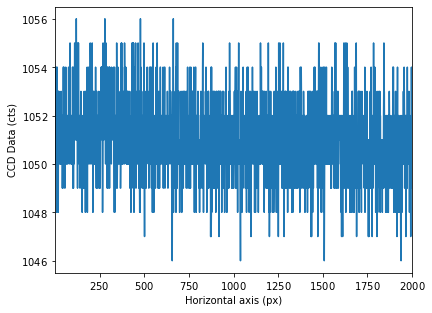

In [10]:
ccd.acquisition_mode('single scan')
ccd.read_mode('full vertical binning')
ccd.preamp_gain(1.)
# Shortest possible exposure time
ccd.exposure_time(0.)

fig, ax = plt.subplots()
ax.plot(ccd.ccd_data.setpoints[0].get(), ccd.ccd_data.get())
ax.set_xlabel(axis_label(ccd.ccd_data.setpoints[0]))
ax.set_ylabel(axis_label(ccd.ccd_data))

### Single track

Text(0, 0.5, 'CCD Data (cts)')

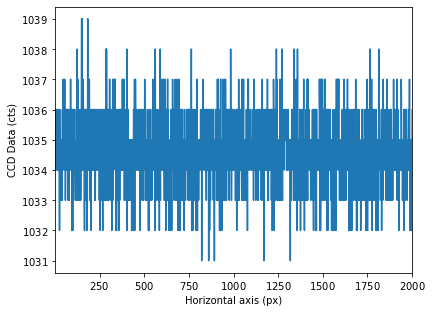

In [11]:
ccd.acquisition_mode('single scan')
ccd.read_mode('single track')
# A single track with center row 118 and 21 rows in height
ccd.single_track_settings((118, 21))

fig, ax = plt.subplots()
ax.plot(ccd.ccd_data.setpoints[0].get(), ccd.ccd_data.get())
ax.set_xlabel(axis_label(ccd.ccd_data.setpoints[0]))
ax.set_ylabel(axis_label(ccd.ccd_data))

### Multi track

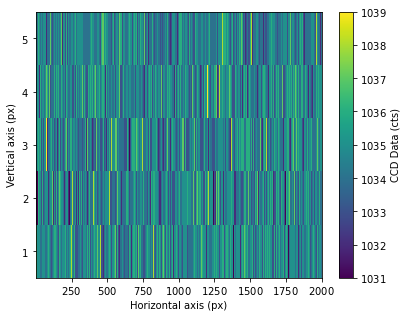

In [12]:
ccd.acquisition_mode('single scan')
ccd.read_mode('multi track')
# 5 tracks 10 px high each offset by 20 px from their nominal center
ccd.multi_track_settings((5, 10, 20))

px, mt = np.meshgrid(*(sp.get() for sp in ccd.ccd_data.setpoints), indexing='ij')
fig, ax = plt.subplots()
img = ax.pcolormesh(mt, px, ccd.ccd_data.get(), shading='nearest')
ax.set_xlabel(axis_label(ccd.ccd_data.setpoints[1]))
ax.set_ylabel(axis_label(ccd.ccd_data.setpoints[0]))
fig.colorbar(img, label=axis_label(ccd.ccd_data))

### Random track

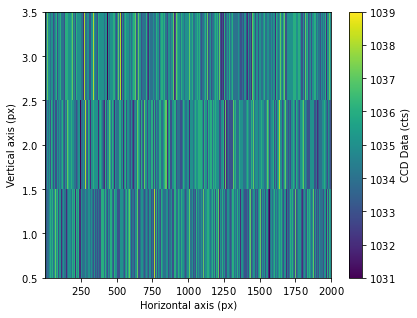

In [13]:
ccd.acquisition_mode('single scan')
ccd.read_mode('random track')
# 3 tracks; rows 10 to 20, rows 50 to 60, and rows 155 to 175
ccd.random_track_settings([3, (10, 20, 50, 60, 155, 175)])

px, rt = np.meshgrid(*(sp.get() for sp in ccd.ccd_data.setpoints), indexing='ij')
fig, ax = plt.subplots()
img = ax.pcolormesh(rt, px, ccd.ccd_data.get(), shading='nearest')
ax.set_xlabel(axis_label(ccd.ccd_data.setpoints[1]))
ax.set_ylabel(axis_label(ccd.ccd_data.setpoints[0]))
fig.colorbar(img, label=axis_label(ccd.ccd_data))

### Image
In image mode, the horizontal and vertical pixel axes (the `setpoints` of the `ccd_data` parameter) are computed according to the following formula:
$$
\mathrm{px} = \mathrm{start} + i \times\mathrm{bin} + \mathrm{bin} // 2, \quad i\in\left[1, (\mathrm{end}-\mathrm{start}) // 2\right]
$$

In [14]:
ccd.acquisition_mode('single scan')
ccd.read_mode('image')
# 2 px binned horizontally, 4 px binned vertically, crop from column 234 to 1821 and row 65 to 192.
ccd.image_settings((4, 4, 234, 1821, 65, 192))
ccd.image_settings()

ImageSettings(hbin=4, vbin=4, hstart=234, hend=1821, vstart=65, vend=192)

In [15]:
ccd.vertical_axis()

array([ 67,  71,  75,  79,  83,  87,  91,  95,  99, 103, 107, 111, 115,
       119, 123, 127, 131, 135, 139, 143, 147, 151, 155, 159, 163, 167,
       171, 175, 179, 183, 187, 191])

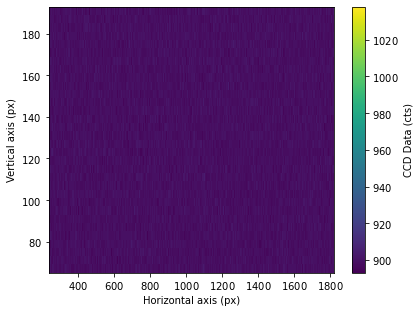

In [16]:
pxx, pxy = np.meshgrid(*(sp.get() for sp in ccd.ccd_data.setpoints), indexing='ij')
fig, ax = plt.subplots()
img = ax.pcolormesh(pxy, pxx, ccd.ccd_data.get(), shading='nearest')
ax.set_xlabel(axis_label(ccd.ccd_data.setpoints[1]))
ax.set_ylabel(axis_label(ccd.ccd_data.setpoints[0]))
fig.colorbar(img, label=axis_label(ccd.ccd_data))

## Acquisition modes
### Accumulate

0.06735000014305115 0.03585999831557274


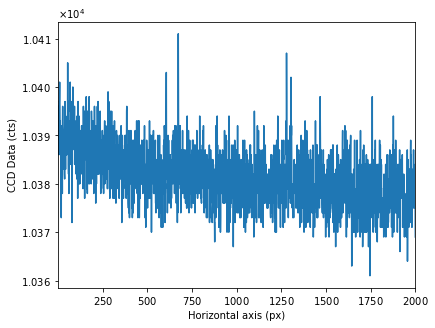

In [17]:
ccd.acquisition_mode('accumulate')
ccd.read_mode('full vertical binning')
# 10 sets of data accumulated into one image
ccd.number_accumulations(10)
ccd.accumulation_cycle_time(0.05)
ccd.exposure_time(0)

fig, ax = plt.subplots()
ax.plot(ccd.ccd_data.setpoints[0].get(), ccd.ccd_data.get())
ax.set_xlabel(axis_label(ccd.ccd_data.setpoints[0]))
ax.set_ylabel(axis_label(ccd.ccd_data))
print(ccd.accumulation_cycle_time(), ccd.exposure_time())

### Kinetics

0.2019599974155426 0.1009799987077713 0.03585999831557274


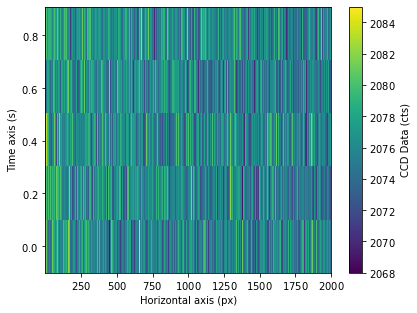

In [18]:
ccd.acquisition_mode('kinetics')
ccd.number_accumulations(2)
ccd.number_kinetics(5)
# 2 sets of data accumulated into one image five times in a row
ccd.kinetic_cycle_time(0.1)
ccd.accumulation_cycle_time(0.05)
ccd.exposure_time(0)

px, t = np.meshgrid(*(sp.get() for sp in ccd.ccd_data.setpoints), indexing='ij')
fig, ax = plt.subplots()
img = ax.pcolormesh(t, px, ccd.ccd_data.get(), shading='nearest')
ax.set_xlabel(axis_label(ccd.ccd_data.setpoints[1]))
ax.set_ylabel(axis_label(ccd.ccd_data.setpoints[0]))
fig.colorbar(img, label=axis_label(ccd.ccd_data))
print(ccd.kinetic_cycle_time(), ccd.accumulation_cycle_time(), ccd.exposure_time())

### Fast kinetics

0.022912850603461266


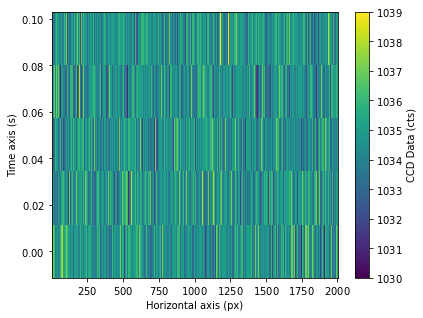

In [19]:
ccd.acquisition_mode('fast kinetics')
# 21 rows to be exposed, 5 images in the kinetic series, 20 ms exposure time, FVB acuquisition mode, 
# 1 px binned horizontally, 1 px binned vertically, 107 rows offset from the bottom (cf single-track)
# The exposure time and number_kinetics settings seem to be independent from their non-fast-kinetics
# counterparts, but are updated in the driver.
ccd.fast_kinetics_settings((21, 5, 20e-3, 0, 1, 1, 107))

px, t = np.meshgrid(*(sp.get() for sp in ccd.ccd_data.setpoints), indexing='ij')
fig, ax = plt.subplots()
img = ax.pcolormesh(t, px, ccd.ccd_data.get(), shading='nearest')
ax.set_xlabel(axis_label(ccd.ccd_data.setpoints[1]))
ax.set_ylabel(axis_label(ccd.ccd_data.setpoints[0]))
fig.colorbar(img, label=axis_label(ccd.ccd_data))
print(ccd.kinetic_cycle_time())

### Run till abort
This mode could be used to implement a live view using a separate thread, but this is currenlty not implemented. Fetching data in this mode by getting `ccd_data` will result in the interpreter being blocked forever.

## Data processing
There exist also `DelegateParameter`s to `ccd_data` which implement different data modes similar to the Andor Solis application. These are
- `ccd_data_bg_corrected`: Data in counts with a background image subtracted
- `ccd_data_per_second`: Data in counts per second (counts divided by the exposure time)
- `ccd_data_bg_corrected_per_second`: Combination of the two

Text(0.5, 0, 'Horizontal axis (px)')

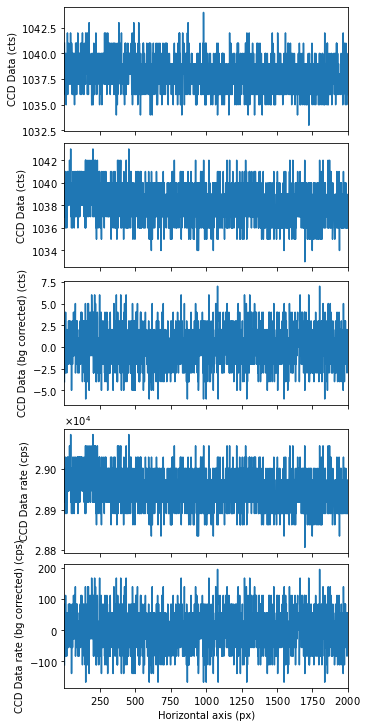

In [20]:
ccd.acquisition_mode('single scan')
ccd.read_mode('full vertical binning')
ccd.exposure_time(0.)

fig, ax = plt.subplots(5, sharex=True, layout='constrained', figsize=(5, 10))
ax[0].plot(ccd.ccd_data.setpoints[0].get(), ccd.background.get())
ax[0].set_ylabel(axis_label(ccd.background))
ax[1].plot(ccd.ccd_data.setpoints[0].get(), ccd.ccd_data.get())
ax[1].set_ylabel(axis_label(ccd.ccd_data))
ax[2].plot(ccd.ccd_data.setpoints[0].get(), ccd.ccd_data_bg_corrected.get_latest())
ax[2].set_ylabel(axis_label(ccd.ccd_data_bg_corrected))
ax[3].plot(ccd.ccd_data.setpoints[0].get(), ccd.ccd_data_rate.get_latest())
ax[3].set_ylabel(axis_label(ccd.ccd_data_rate))
ax[4].plot(ccd.ccd_data.setpoints[0].get(), ccd.ccd_data_rate_bg_corrected.get_latest())
ax[4].set_ylabel(axis_label(ccd.ccd_data_rate_bg_corrected))
ax[4].set_xlabel(axis_label(ccd.ccd_data.setpoints[0]))

In [ ]:
ccd.warm_up()
ccd.close()

ccd warming up from -59°C to 15°C. Delta:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 70/74 [02:54<00:09,  2.50s/°C]